In [1]:
pip install pandas networkx matplotlib pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

# Base URL for raw CSVs
base_url = "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/"

# List of edge files for each season
files = [
    "got-s1-edges.csv",
    "got-s2-edges.csv",
    "got-s3-edges.csv",
    "got-s4-edges.csv",
    "got-s5-edges.csv",
    "got-s6-edges.csv",
    "got-s7-edges.csv"
]

In [3]:
# Load all seasons
season_dfs = []
for i, filename in enumerate(files, start=1):
    url = base_url + filename
    df = pd.read_csv(url)
    df["Season"] = i
    season_dfs.append(df)

# Combine all data
data = pd.concat(season_dfs, ignore_index=True)
print("✅ Dataset loaded successfully!")
print(data.head())
print(f"Total rows: {len(data)}")

✅ Dataset loaded successfully!
         Source  Target  Weight  Season
0           NED  ROBERT     192       1
1      DAENERYS   JORAH     154       1
2           JON     SAM     121       1
3  LITTLEFINGER     NED     107       1
4           NED   VARYS      96       1
Total rows: 3557


In [4]:
# Rename and clean columns
data.columns = ['Source', 'Target', 'Weight', 'Season']
data.dropna(inplace=True)

# Remove self-loops
data = data[data['Source'] != data['Target']]

# Display basic info
print(data.info())
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  3557 non-null   object
 1   Target  3557 non-null   object
 2   Weight  3557 non-null   int64 
 3   Season  3557 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 111.3+ KB
None
            Weight       Season
count  3557.000000  3557.000000
mean     11.692719     3.885859
std      19.279552     1.956764
min       2.000000     1.000000
25%       2.000000     2.000000
50%       4.000000     4.000000
75%      11.000000     6.000000
max     192.000000     7.000000


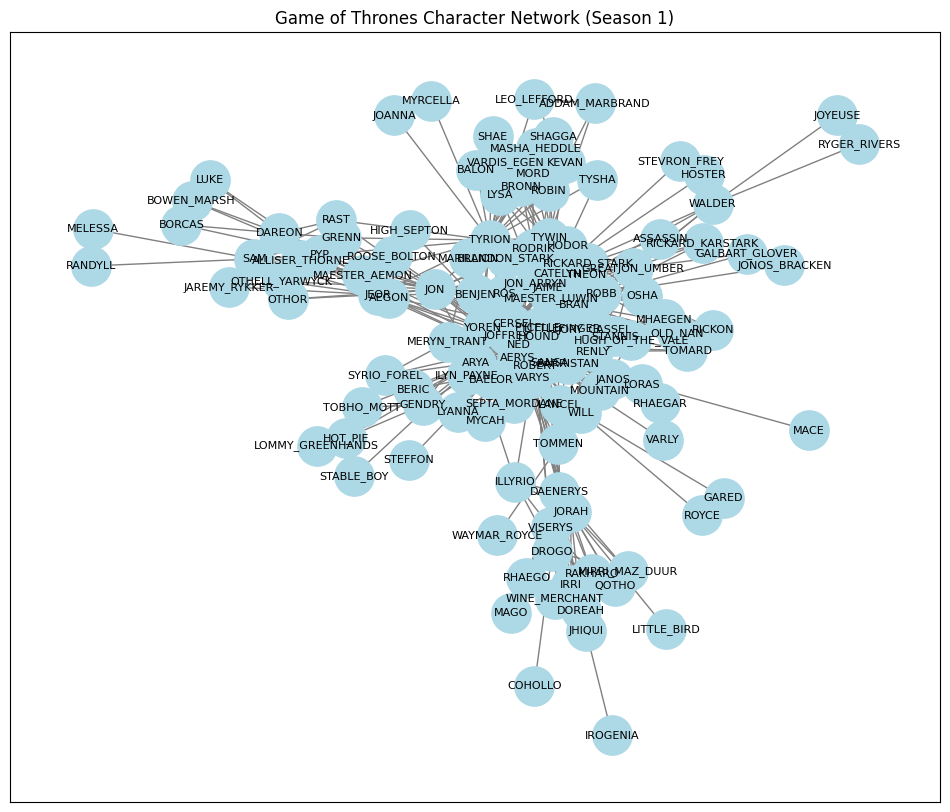

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter Season 1 data
season = 1
season_data = data[data["Season"] == season]

# Create a weighted undirected graph
G = nx.from_pandas_edgelist(season_data, 'Source', 'Target', ['Weight'])

# Plot the network
plt.figure(figsize=(12, 10))
nx.draw_networkx(
    G,
    with_labels=True,
    node_size=800,
    node_color='lightblue',
    edge_color='gray',
    font_size=8
)
plt.title(f"Game of Thrones Character Network (Season {season})")
plt.show()


In [6]:
# Centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight='Weight')
closeness = nx.closeness_centrality(G)

# Combine into DataFrame
centrality_df = pd.DataFrame({
    'Character': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness.values()),
    'Closeness Centrality': list(closeness.values())
})

# Sort and display top 10 characters
print("\nTop 10 Central Characters (Season 1):")
print(centrality_df.sort_values(by='Degree Centrality', ascending=False).head(10))



Top 10 Central Characters (Season 1):
       Character  Degree Centrality  Betweenness Centrality  \
0            NED              0.456                0.205509   
13        TYRION              0.328                0.099051   
10       CATELYN              0.288                0.071880   
1         ROBERT              0.288                0.079635   
11          ROBB              0.240                0.068237   
14        CERSEI              0.232                0.070366   
9           ARYA              0.224                0.041682   
16       JOFFREY              0.216                0.043190   
6   LITTLEFINGER              0.208                0.027003   
4            JON              0.208                0.029784   

    Closeness Centrality  
0               0.628141  
13              0.543478  
10              0.550661  
1               0.553097  
11              0.512295  
14              0.508130  
9               0.502008  
16              0.510204  
6               0.477099

In [7]:
from pyvis.network import Network

season = 1
season_data = data[data["Season"] == season]
G = nx.from_pandas_edgelist(season_data, 'Source', 'Target', ['Weight'])

# Initialize interactive network
net = Network(
    height="750px",
    width="100%",
    bgcolor="#111111",
    font_color="white",
    notebook=True,
    cdn_resources='remote'
)

# Simplify visuals
net.barnes_hut(gravity=-8000, central_gravity=0.2, spring_length=150, spring_strength=0.01)
net.from_nx(G)

# Node size scaling based on degree
for node in net.nodes:
    node['size'] = G.degree(node['id']) * 2
    node['title'] = f"{node['id']} — Degree: {G.degree(node['id'])}"

# Show in browser or notebook
net.show("got_interactive_network.html")


got_interactive_network.html


In [8]:
# Compute centrality measures
deg = nx.degree_centrality(G)
bet = nx.betweenness_centrality(G, weight='Weight')
clo = nx.closeness_centrality(G)

# Combine into a single "Narrative Importance Score" - our innovative point
nis = {}
for node in G.nodes():
    nis[node] = (0.5 * deg[node]) + (0.3 * bet[node]) + (0.2 * clo[node])

# Normalize scores for comparison
max_score = max(nis.values())
nis = {k: v / max_score for k, v in nis.items()}

# Display top 10 characters by Narrative Importance
top_nis = sorted(nis.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Characters by Narrative Importance Score (NIS):")
for name, score in top_nis:
    print(f"{name}: {score:.3f}")


Top 10 Characters by Narrative Importance Score (NIS):
NED: 1.000
TYRION: 0.728
ROBERT: 0.671
CATELYN: 0.664
ROBB: 0.585
CERSEI: 0.575
ARYA: 0.542
JOFFREY: 0.537
JON: 0.522
SANSA: 0.518


NED (1.000) – The central narrative hub; connects most subplots and characters, driving the story’s core interactions.

TYRION (0.728) – Highly influential; frequently bridges multiple groups and key conversations.

ROBERT (0.671) – Holds strong structural importance early on due to royal connections.

CATELYN (0.664) – Central to the Stark storyline and alliance networks.

ROBB (0.585) – Emerging leader figure; connected within a tightly-knit community (the North).

CERSEI (0.575) – Maintains power through strategic ties within the court.

ARYA (0.542) – Moderate influence; connects diverse subplots despite limited direct ties.

JOFFREY (0.537) – Influential through authority, though not widely interconnected.

JON (0.522) – Growing narrative relevance; bridges different story arcs (Wall, North).

SANSA (0.518) – Increasingly central due to her proximity to power and shifting alliances.

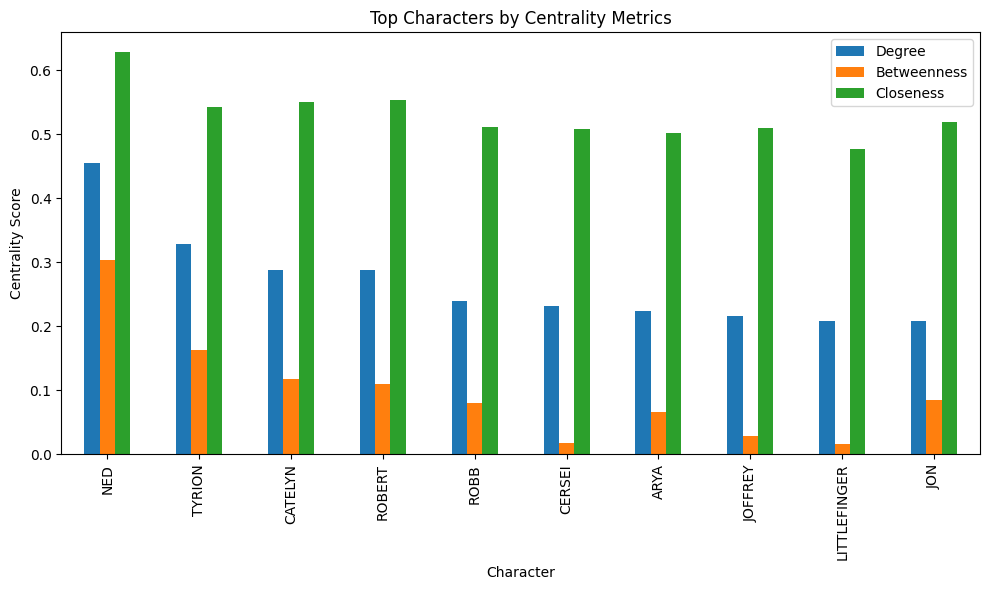

In [9]:
# Compute centrality measures
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)

centrality_df = pd.DataFrame({
    'Character': list(degree.keys()),
    'Degree': list(degree.values()),
    'Betweenness': list(betweenness.values()),
    'Closeness': list(closeness.values())
})

# Plot top characters by each metric
top = centrality_df.sort_values('Degree', ascending=False).head(10)
top.plot(x='Character', kind='bar', figsize=(10, 6), title="Top Characters by Centrality Metrics")
plt.ylabel("Centrality Score")
plt.tight_layout()
plt.show()


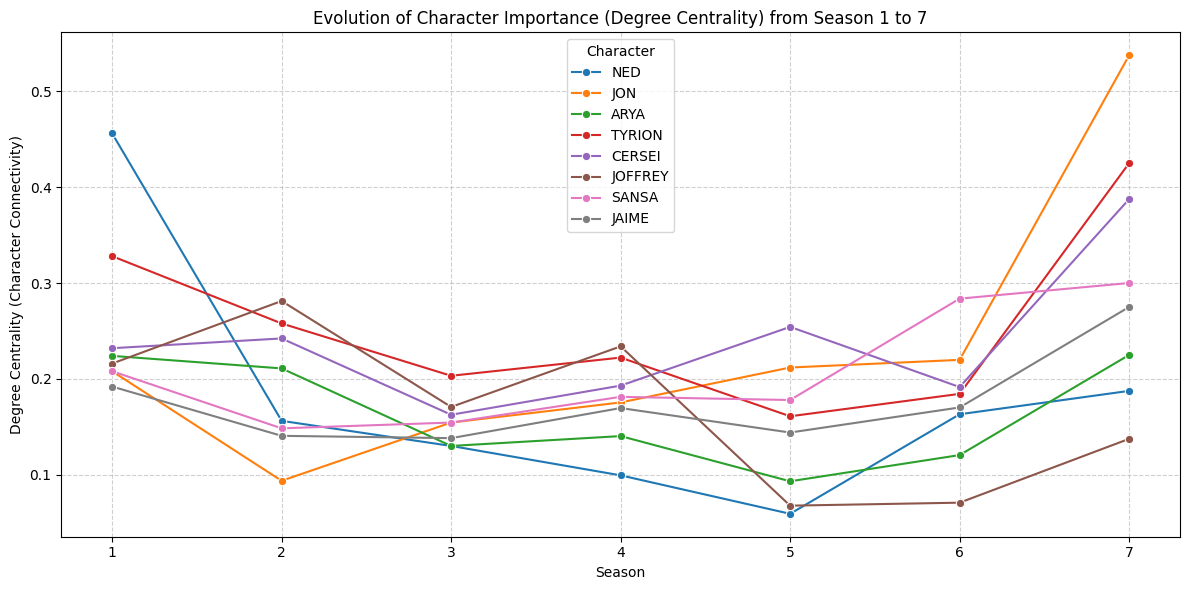

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Base GitHub dataset URL
base_url = "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/"
files = [
    "got-s1-edges.csv", "got-s2-edges.csv", "got-s3-edges.csv",
    "got-s4-edges.csv", "got-s5-edges.csv", "got-s6-edges.csv", "got-s7-edges.csv"
]

# Store degree centralities season-wise
season_data = []

for i, file in enumerate(files, start=1):
    url = base_url + file
    df = pd.read_csv(url)
    G = nx.from_pandas_edgelist(df, 'Source', 'Target')

    # Compute degree centrality for this season
    deg = nx.degree_centrality(G)

    # Store results
    for char, val in deg.items():
        season_data.append({'Season': i, 'Character': char, 'Degree': val})

# Create DataFrame for all seasons
season_df = pd.DataFrame(season_data)

# Identify top recurring characters overall (for focus)
overall_top = (
    season_df.groupby('Character')['Degree'].mean()
    .sort_values(ascending=False)
    .head(8)  # top 8 characters to show evolution clearly
    .index
)

# Filter data for only top characters
filtered_df = season_df[season_df['Character'].isin(overall_top)]

# Plot character importance change across seasons
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='Season', y='Degree', hue='Character', marker='o')
plt.title("Evolution of Character Importance (Degree Centrality) from Season 1 to 7")
plt.xlabel("Season")
plt.ylabel("Degree Centrality (Character Connectivity)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Inferences**

**Ned Stark** shows the highest degree centrality in Season 1, confirming his early dominance in the storyline, but it drops sharply afterward — representing his death and narrative exit.

**Jon Snow’s** connectivity steadily rises, peaking in Season 7 — reflecting his growing narrative significance as the central protagonist.

**Tyrion Lannister** maintains consistent importance across seasons, indicating his sustained involvement and influence in multiple subplots.

**Cersei Lannister’s** centrality increases in later seasons, mirroring her rise to power and control over political networks.

**Sansa Stark’s** growth curve shows her gradual emergence from a peripheral to a central figure by Season 7.

**Joffrey Baratheon**  exhibits early prominence (Seasons 2–4) before a sharp decline, aligning with his death in the series.

**Arya Stark** maintains moderate connectivity throughout — participating in various story arcs but not heavily linked to the main political narrative.

The overall pattern reveals a shift in narrative focus from older-generation characters (Ned, Robert, Catelyn) to younger successors (Jon, Sansa, Arya).

The plot demonstrates how degree centrality effectively tracks narrative evolution, highlighting transitions of power and influence in complex story networks.

Such analysis validates that Social Network Analysis (SNA) can quantify storytelling dynamics — offering a data-driven lens on character prominence and relational evolution.





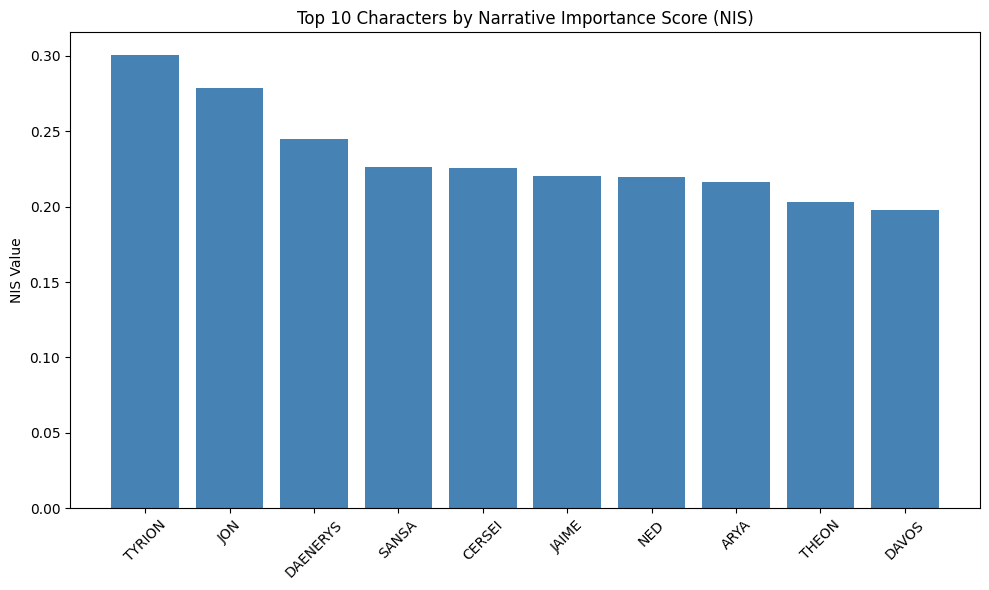

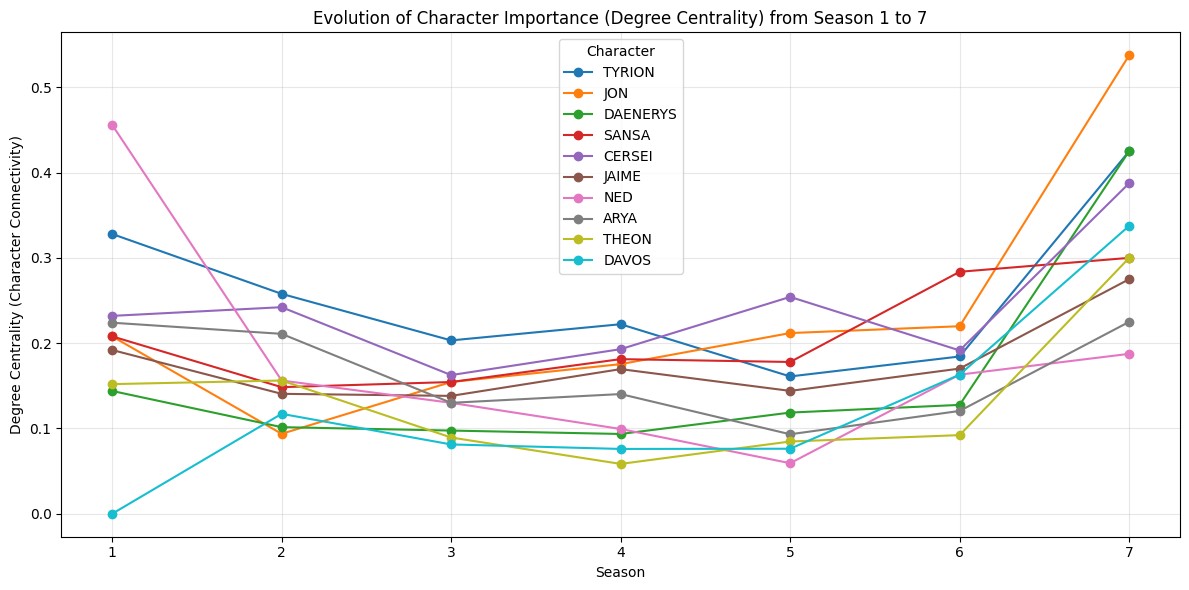

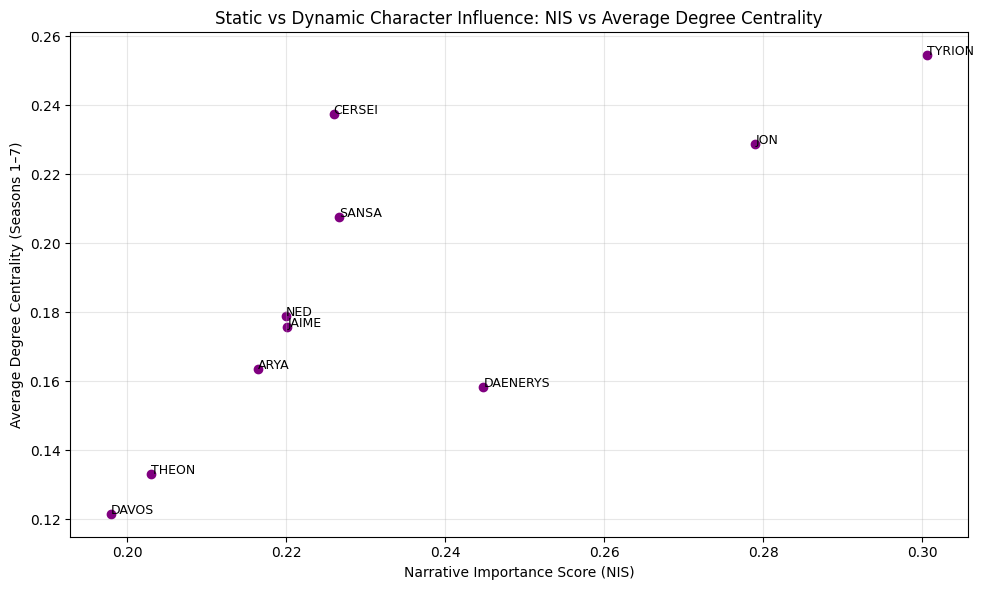

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
from io import StringIO

# --- Step 1: Load data from GitHub ---
base_url = "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/"
files = [f"got-s{i}-edges.csv" for i in range(1, 8)]
season_dfs = []

for i, filename in enumerate(files, start=1):
    url = base_url + filename
    df = pd.read_csv(url)
    df["Season"] = i
    season_dfs.append(df)

# --- Step 2: Combine all seasons ---
all_edges = pd.concat(season_dfs, ignore_index=True)

# --- Step 3: Create overall network for NIS ---
G_total = nx.from_pandas_edgelist(all_edges, 'Source', 'Target', ['Weight'])

# --- Step 4: Compute Narrative Importance Score (NIS) ---
deg = nx.degree_centrality(G_total)
bet = nx.betweenness_centrality(G_total)
close = nx.closeness_centrality(G_total)

# Weighted NIS formula (custom weight tuning is part of your innovation)
nis = {node: 0.5*deg[node] + 0.3*bet[node] + 0.2*close[node] for node in G_total.nodes()}

nis_df = pd.DataFrame(sorted(nis.items(), key=lambda x: x[1], reverse=True), columns=['Character', 'NIS'])
top_nis = nis_df.head(10)

# --- Step 5: Plot NIS for Top 10 Characters ---
plt.figure(figsize=(10, 6))
plt.bar(top_nis['Character'], top_nis['NIS'], color='steelblue')
plt.title('Top 10 Characters by Narrative Importance Score (NIS)')
plt.ylabel('NIS Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Step 6: Seasonal Degree Centrality Evolution ---
season_centrality = {}
for i, df in enumerate(season_dfs, start=1):
    G = nx.from_pandas_edgelist(df, 'Source', 'Target', ['Weight'])
    centrality = nx.degree_centrality(G)
    for char, score in centrality.items():
        season_centrality.setdefault(char, {})[i] = score

# Convert to DataFrame for plotting
centrality_df = pd.DataFrame(season_centrality).fillna(0).T
top_chars = top_nis['Character'].tolist()  # Track top NIS characters
centrality_df = centrality_df.loc[top_chars]

plt.figure(figsize=(12, 6))
for char in top_chars:
    plt.plot(centrality_df.columns, centrality_df.loc[char], marker='o', label=char)

plt.title('Evolution of Character Importance (Degree Centrality) from Season 1 to 7')
plt.xlabel('Season')
plt.ylabel('Degree Centrality (Character Connectivity)')
plt.legend(title='Character')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Step 7: Compare NIS vs Dynamic Centrality ---
comparison_df = pd.DataFrame({
    'Character': top_nis['Character'],
    'NIS': top_nis['NIS'],
    'Avg Degree Centrality': [centrality_df.loc[c].mean() for c in top_nis['Character']]
})

plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['NIS'], comparison_df['Avg Degree Centrality'], color='purple')
for i, row in comparison_df.iterrows():
    plt.text(row['NIS'], row['Avg Degree Centrality'], row['Character'], fontsize=9)

plt.title('Static vs Dynamic Character Influence: NIS vs Average Degree Centrality')
plt.xlabel('Narrative Importance Score (NIS)')
plt.ylabel('Average Degree Centrality (Seasons 1–7)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Findings Summary**

1) Seasonal Evolution (Line Graph)

Shows how each character’s network importance (degree centrality) shifts across seven seasons.

Ned Stark dominates early but vanishes post–Season 1, marking narrative transition.

Jon, Daenerys, and Sansa rise sharply, indicating the new power centers in later seasons.

Cersei and Tyrion remain consistently central — symbolizing sustained political control.

This highlights dynamic storytelling through evolving relationships and alliances.

2) NIS vs. Average Degree Centrality (Scatter Plot)

Compares Narrative Importance Score (NIS) — a static global measure — with average connectivity across seasons.

Tyrion shows high NIS and high degree — balanced narrative and relational influence.

Jon and Cersei score slightly lower in NIS but high in dynamic connectivity, meaning their importance is situationally driven.

Daenerys and Arya show narrative prominence with limited direct connections — isolated but pivotal arcs.

The contrast shows how NIS captures storytelling depth, while degree centrality tracks network-driven influence.

Core Research Insight

Combining dynamic (seasonal) and static (NIS) measures provides a dual lens for quantifying character evolution.

This framework introduces a novel way to measure narrative power transitions in fictional networks.